# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [Fake news RAMP](http://www.ramp.studio/problems/fake_news): classify statements of public figures

_Emanuela Boros (LIMSI/CNRS), Balázs Kégl (LAL/CNRS)_

## Introduction
This is an initiation project to introduce RAMP and get you to know how it works.

The goal is to develop prediction models able to **identify which news is fake**. 

The data we will manipulate is from http://www.politifact.com. The input contains of short statements of public figures (and sometimes anomymous bloggers), plus some metadata. The output is a truth level, judged by journalists at Politifact. They use six truth levels which we coded into integers to obtain an [ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression) problem:
```
0: 'Pants on Fire!'
1: 'False'
2: 'Mostly False'
3: 'Half-True'
4: 'Mostly True'
5: 'True'
```
You goal is to classify each statement (+ metadata) into one of the categories.

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.19.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   
* seaborn>=0.7.1
* nltk

Further, an nltk dataset needs to be downloaded:

```
python -m nltk.downloader popular
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Exploratory data analysis

### Loading the data

In [2]:
train_filename = 'data/train.csv'
data = pd.read_csv(train_filename, sep='\t')
data = data.fillna('')
data['date'] = pd.to_datetime(data['date'])
data

,date,edited_by,job,researched_by,source,state,statement,subjects,truth
0,2013-08-29,Angie Drobnic Holan,Republican,Jon Greenberg,Scott Walker,Wisconsin,"In the Wisconsin health insurance exchange, ""t...",['Health Care'],3
1,2013-08-29,Angie Drobnic Holan,Republican,Louis Jacobson,Mike Huckabee,Arkansas,"""America’s gun-related homicide rate … would b...","['Crime', 'Guns', 'Pundits']",0
2,2013-08-29,Greg Borowski,,Tom Kertscher,League of Conservation Voters,,Says U.S. Sen. Ron Johnson voted to let oil an...,"['Climate Change', 'Energy', 'Environment', 'T...",5
3,2013-08-28,Aaron Sharockman,,Rochelle Koff,National Republican Congressional Committee,,"""Congressman Patrick Murphy voted to keep the ...",['Health Care'],2
4,2013-08-28,Aaron Sharockman,,Angie Drobnic Holan,Janet Napolitano,,"The 2010 DREAM Act failed despite ""strong bipa...","['Bipartisanship', 'Immigration']",2
5,2013-08-28,W. Gardner Selby,Republican,Sue Owen,Steve Stockman,Texas,"Says U.N. arms treaty will mandate a ""new inte...",['Guns'],1
6,2013-08-28,Greg Borowski,Democrat,Dave Umhoefer,Mark Harris,Wisconsin,"""I’ve got the spending down, I’ve got the debt...","['County Budget', 'County Government', 'Debt',...",4
7,2013-08-28,"Jim Denery, Jim Tharpe",Democrat,Eric Stirgus,Doug Stoner,Georgia,"""I fought hard for that (state Senate) seat. I...","['Campaign Finance', 'Candidate Biography']",2
8,2013-08-27,Angie Drobnic Holan,None,Louis Jacobson,Moms Demand Action for Gun Sense In America,Indiana,"The book Little Red Riding Hood is something ""...","['Education', 'Guns']",2
9,2013-08-27,Angie Drobnic Holan,,Julie Kliegman,BookerFail,,"""Three years after getting the $100 million (f...",['Education'],2


In [3]:
data.dtypes

date             datetime64[ns]
edited_by                object
job                      object
researched_by            object
source                   object
state                    object
statement                object
subjects                 object
truth                     int64
dtype: object

In [4]:
data.describe()

,truth
count,7569.000000
mean,2.740917
std,1.588681
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,5.000000


In [5]:
data.count()

date             7569
edited_by        7569
job              7569
researched_by    7569
source           7569
state            7569
statement        7569
subjects         7569
truth            7569
dtype: int64

The original training data frame has 13000+ instances. In the starting kit, we give you a subset of 7569 instances for training and 2891 instances for tesing.

Most columns are categorical, some have high cardinalities.

['' 'Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'Rhode island'
 'South Carolina' 'South Dakota' 'Tennesse' 'Tennessee' 'Texas'
 'United Kingdom' 'Utah' 'Vermont' 'Virgina' 'Virginia' 'Washington'
 'Washington state' 'Washington, D.C.' 'West Virginia' 'Wisconsin'
 'Wyoming' 'ohio' 'the United States']
60


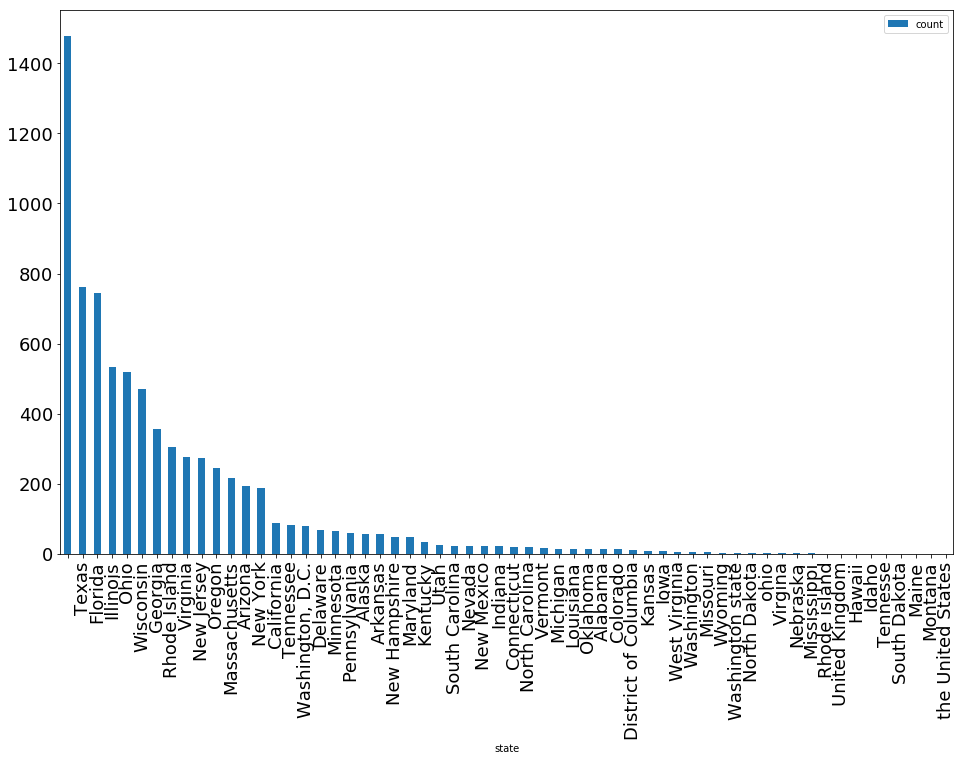

In [6]:
print(np.unique(data['state']))
print(len(np.unique(data['state'])))
data.groupby('state').count()[['job']].sort_values(
    'job', ascending=False).reset_index().rename(
    columns={'job': 'count'}).plot.bar(
    x='state', y='count', figsize=(16, 10), fontsize=18);

['' 'Activist' 'Business leader' 'Columnist' 'Constitution Party'
 'Democrat' 'Democratic Farmer-Labor' 'Independent' 'Journalist'
 'Labor leader' 'Libertarian' 'Newsmaker' 'None'
 'Ocean State Tea Party in Action' 'Organization' 'Republican'
 'State official' 'Talk show host' 'Tea Party member' 'county commissioner']
20


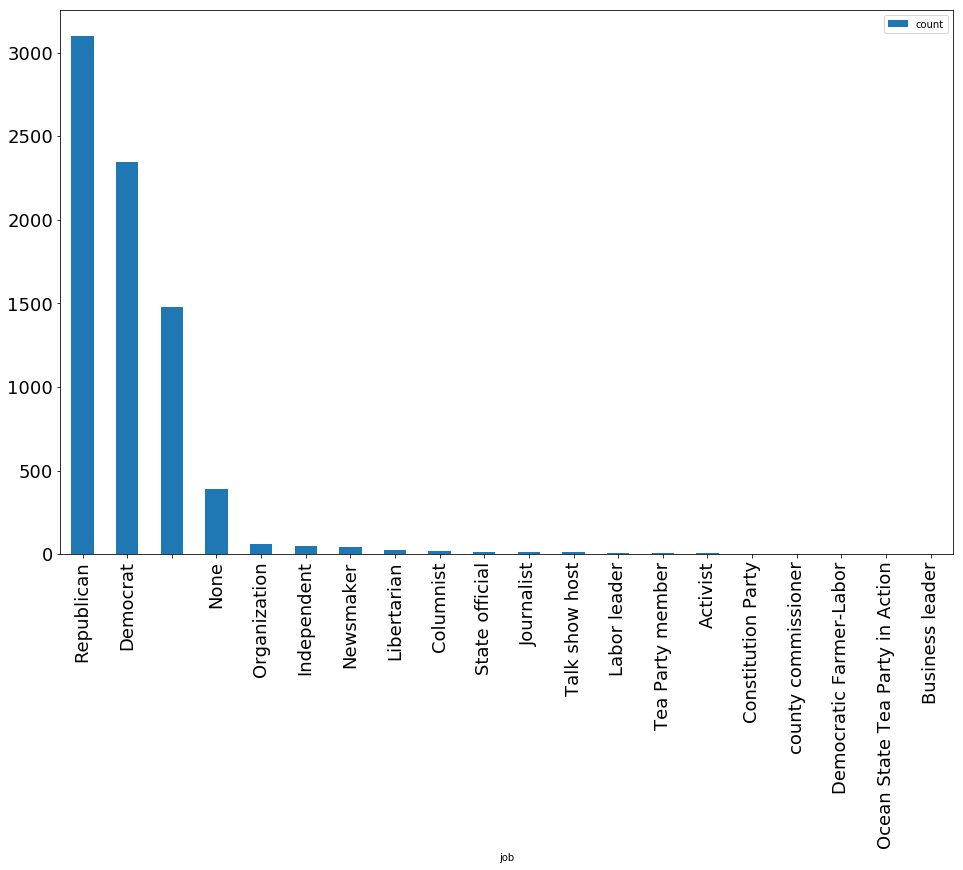

In [7]:
print(np.unique(data['job']))
print(len(np.unique(data['job'])))
data.groupby('job').count()[['state']].rename(
    columns={'state': 'count'}).sort_values(
    'count', ascending=False).reset_index().plot.bar(
        x='job', y='count', figsize=(16, 10), fontsize=18);

If you want to use the journalist and the editor as input, you will need to split the lists since somtimes there are more than one of them on an instance.

['' 'Aaron Sharockman' 'Adriel Bettelheim, Amy Hollyfield' 'Alexander Lane'
 'Amy Hollyfield' 'Amy Hollyfield, Aaron Sharockman'
 'Amy Hollyfield, Greg Joyce' 'Amy Hollyfield, Scott Montgomery'
 'Amy Sherman' 'Angie Drobnic Holan'
 'Angie Drobnic Holan, Aaron Sharockman'
 'Angie Drobnic Holan, Elizabeth Miniet, Jim Tharpe' 'Bill Adair'
 'Bill Adair, Aaron Sharockman' 'Bill Adair, Amy Hollyfield'
 'Bill Adair, Angie Drobnic Holan' 'Bill Adair, Martha M. Hamilton'
 'Bill Adair, Scott Montgomery' 'Bill Adair, Sergio Bustos'
 'Bill Adair, Steve Ahillen, Zack McMillin' 'Bill Adair, Tom Chester'
 'Bill Adair, Tom Chester, Michael Erskine' 'Bill Adair, W. Gardner Selby'
 'Bill Adair, Zack McMillin' 'Bill Duryea' 'Bob Gee' 'Brenda Bell'
 'Brenda Bell, Jody Seaborn' 'Brenda Bell, W. Gardner Selby'
 'Bridget Hall Grumet' 'Bridget Hall Grumet, Angie Drobnic Holan'
 'Bruce  Hammond' 'C. Eugene Emery Jr.' 'Caryn Shinske' 'Catharine Richert'
 'Charles Gay' 'Charles Gay, Elizabeth Miniet' 'Chris Quin

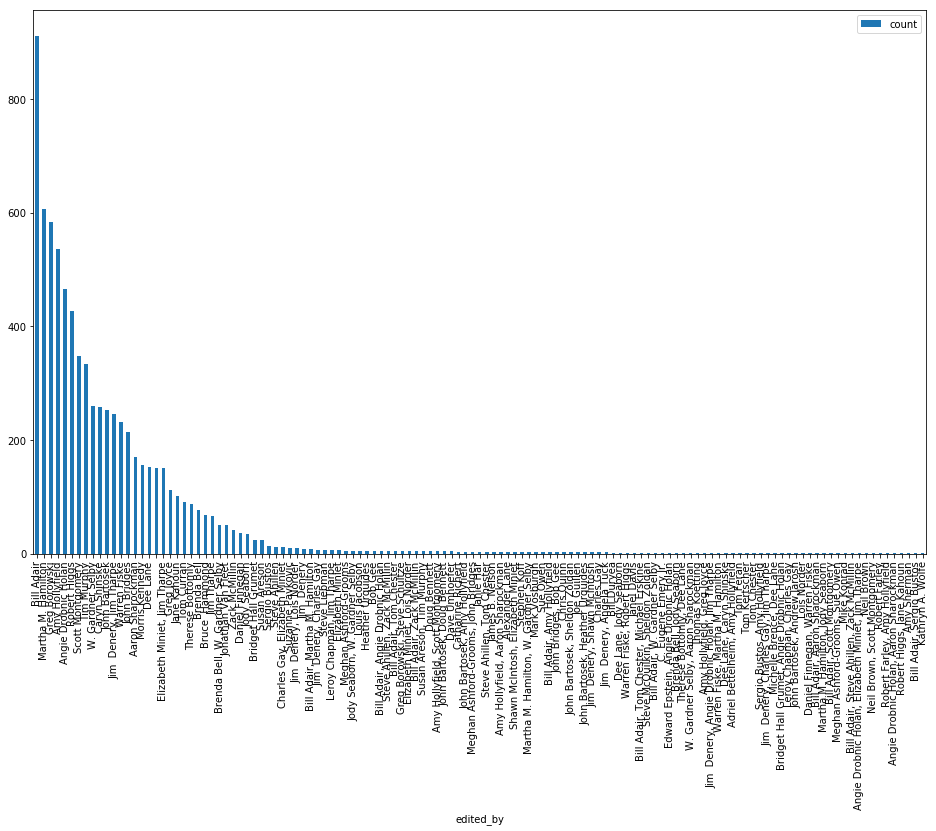

In [8]:
print(np.unique(data['edited_by']))
print(len(np.unique(data['edited_by'])))
data.groupby('edited_by').count()[['state']].rename(
    columns={'state': 'count'}).sort_values(
    'count', ascending=False).reset_index().plot.bar(
        x='edited_by', y='count', figsize=(16, 10), fontsize=10);

In [9]:
print(np.unique(data['researched_by']))
print(len(np.unique(data['researched_by'])))

['' 'Aaron Marshall' 'Aaron Sharockman' 'Aaron Sharockman, Amy Sherman'
 'Adriel Bettelheim' 'Adriel Bettelheim, Angie Drobnic Holan'
 'Adriel Bettelheim, David DeCamp' 'Adriel Bettelheim, Ryan Kelly'
 'Alaina Berner, Christopher Connors, Louis Jacobson' 'Alex Holt'
 'Alex Holt, Louis Jacobson' 'Alex Holt, Michelle Sutherland'
 'Alex Kuffner' 'Alex Leary' 'Alexander Lane' 'Amy Hollyfield'
 'Amy Sherman' 'Amy Sherman, Bartholomew Sullivan' 'Andra Lim'
 'Angie Drobnic Holan' 'Angie Drobnic Holan, Aaron Sharockman'
 'Angie Drobnic Holan, Alex Leary' 'Angie Drobnic Holan, Alexander Lane'
 'Angie Drobnic Holan, Amy Sherman'
 'Angie Drobnic Holan, Amy Sherman, Dave Umhoefer'
 'Angie Drobnic Holan, Catharine Richert'
 'Angie Drobnic Holan, Craig Pittman'
 'Angie Drobnic Holan, David G. Taylor'
 'Angie Drobnic Holan, Ian K. Kullgren'
 'Angie Drobnic Holan, Jeffrey S.  Solochek'
 'Angie Drobnic Holan, John Martin' 'Angie Drobnic Holan, Katie Sanders'
 'Angie Drobnic Holan, Louis Jacobson'
 'Ang

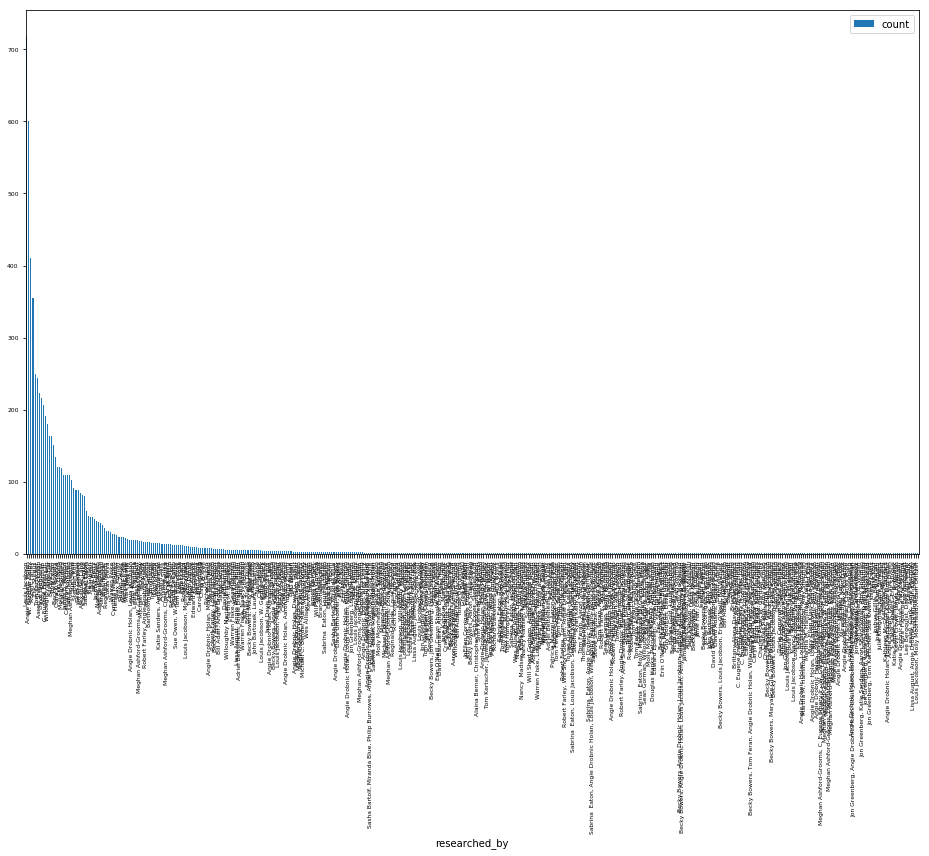

In [10]:
data.groupby('researched_by').count()[['state']].sort_values(
    'state', ascending=False).reset_index().rename(
    columns={'state': 'count'}).plot.bar(
        x='researched_by', y='count', figsize=(16, 10), fontsize=6);

There are 2000+ different sources.

['13th District GOP slate' '18% of the American public'
 '60 Plus Association' ..., 'Zell Miller' 'Zoe Lofgren' 'billhislam.com']
2124


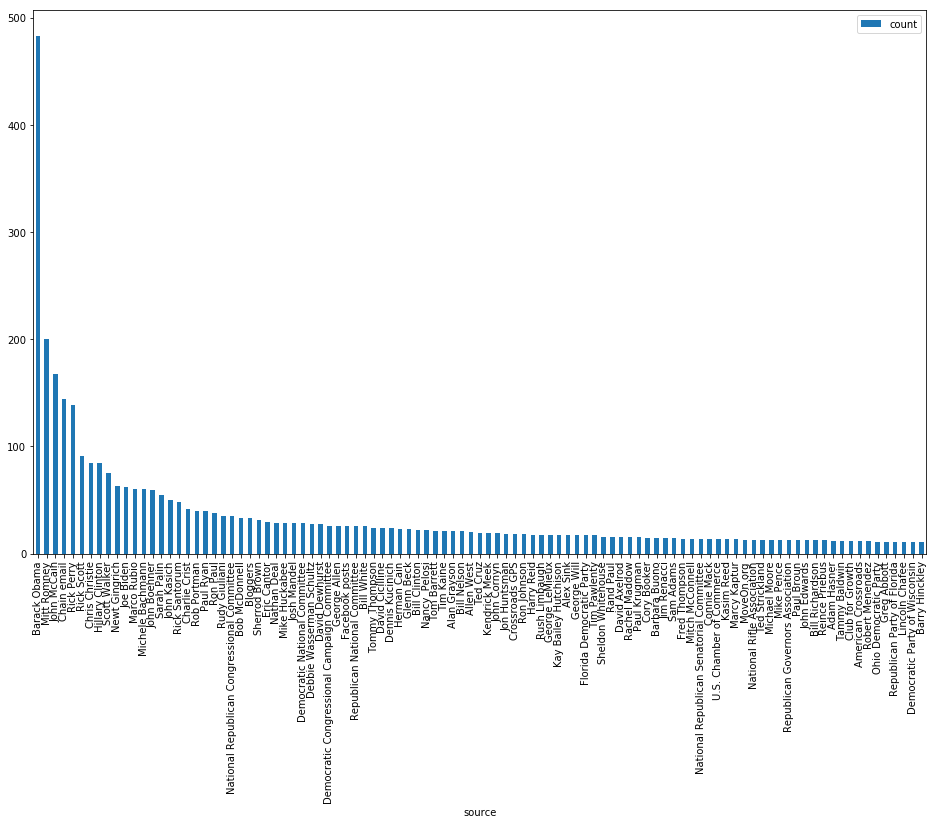

In [11]:
print(np.unique(data['source']))
print(len(np.unique(data['source'])))
data.groupby('source').count()[['state']].rename(
    columns={'state': 'count'}).sort_values(
    'count', ascending=False).reset_index().loc[:100].plot.bar(
        x='source', y='count', figsize=(16, 10), fontsize=10);

### Predicting truth level

The goal is to predict the truthfulness of statements. Let us group the data according to the `truth` columns:

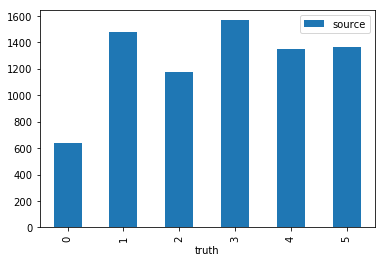

In [12]:
data.groupby('truth').count()[['source']].reset_index().plot.bar(x='truth', y='source');

In [31]:
#### Data

import problem
X_, y_ = problem.get_train_data()


In [32]:
X_

,date,edited_by,job,researched_by,source,state,statement,subjects
0,2013-08-29,Angie Drobnic Holan,Republican,Jon Greenberg,Scott Walker,Wisconsin,"In the Wisconsin health insurance exchange, ""t...",['Health Care']
1,2013-08-29,Angie Drobnic Holan,Republican,Louis Jacobson,Mike Huckabee,Arkansas,"""America’s gun-related homicide rate … would b...","['Crime', 'Guns', 'Pundits']"
2,2013-08-29,Greg Borowski,NaN,Tom Kertscher,League of Conservation Voters,NaN,Says U.S. Sen. Ron Johnson voted to let oil an...,"['Climate Change', 'Energy', 'Environment', 'T..."
3,2013-08-28,Aaron Sharockman,NaN,Rochelle Koff,National Republican Congressional Committee,NaN,"""Congressman Patrick Murphy voted to keep the ...",['Health Care']
4,2013-08-28,Aaron Sharockman,NaN,Angie Drobnic Holan,Janet Napolitano,NaN,"The 2010 DREAM Act failed despite ""strong bipa...","['Bipartisanship', 'Immigration']"
5,2013-08-28,W. Gardner Selby,Republican,Sue Owen,Steve Stockman,Texas,"Says U.N. arms treaty will mandate a ""new inte...",['Guns']
6,2013-08-28,Greg Borowski,Democrat,Dave Umhoefer,Mark Harris,Wisconsin,"""I’ve got the spending down, I’ve got the debt...","['County Budget', 'County Government', 'Debt',..."
7,2013-08-28,"Jim Denery, Jim Tharpe",Democrat,Eric Stirgus,Doug Stoner,Georgia,"""I fought hard for that (state Senate) seat. I...","['Campaign Finance', 'Candidate Biography']"
8,2013-08-27,Angie Drobnic Holan,None,Louis Jacobson,Moms Demand Action for Gun Sense In America,Indiana,"The book Little Red Riding Hood is something ""...","['Education', 'Guns']"
9,2013-08-27,Angie Drobnic Holan,NaN,Julie Kliegman,BookerFail,NaN,"""Three years after getting the $100 million (f...",['Education']


## The pipeline

For submitting at the [RAMP site](http://ramp.studio), you will have to write two classes, saved in two different files:   
* the class `FeatureExtractor`, which will be used to extract features for classification from the dataset and produce a numpy array of size (number of samples $\times$ number of features). 
* a class `Classifier` to predict 

### Feature extractor

The feature extractor implements a `transform` member function. It is saved in the file [`submissions/starting_kit/feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py). It receives the pandas dataframe `X_df` defined at the beginning of the notebook. It should produce a numpy array representing the extracted features, which will then be used for the classification.  

Note that the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [180]:
#%%file submissions/starting_kit/feature_extractor.py
# -*- coding: utf-8 -*-
from __future__ import unicode_literals

import numpy as np
import string
import unicodedata

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler

def clean_str(sentence, stem=True):
    english_stopwords = set(
        [stopword for stopword in stopwords.words('english')])
    punctuation = set(string.punctuation)
    punctuation.update(["``", "`", "..."])
    if stem:
        stemmer = SnowballStemmer('english')
        return list((filter(lambda x: x.lower() not in english_stopwords and
                            x.lower() not in punctuation,
                            [stemmer.stem(t.lower())
                             for t in word_tokenize(sentence)
                             if t.isalpha()])))

    return list((filter(lambda x: x.lower() not in english_stopwords and
                        x.lower() not in punctuation,
                        [t.lower() for t in word_tokenize(sentence)
                         if t.isalpha()])))


def strip_accents_unicode(s):
    try:
        s = unicode(s, 'utf-8')
    except NameError:  # unicode is a default on python 3
        pass
    s = unicodedata.normalize('NFD', s)
    s = s.encode('ascii', 'ignore')
    s = s.decode("utf-8")
    return str(s)

from sklearn.feature_extraction.text import TfidfVectorizer
class FeatureExtractor(TfidfVectorizer):
    """Convert a collection of raw documents to a matrix of TF-IDF features. """

    def __init__(self):
        super(FeatureExtractor, self).__init__(
            input='content', encoding='utf-8',
            decode_error='strict', strip_accents=None, lowercase=True,
            preprocessor=None, tokenizer=None, analyzer='word',
            stop_words=None, token_pattern=r"(?u)\b\w\w+\b",
            ngram_range=(1, 1), max_df=1.0, min_df=1,
            max_features=None, vocabulary=None, binary=False,
            dtype=np.int64, norm='l2', use_idf=True, smooth_idf=True,
            sublinear_tf=False)

    def fit(self, X_df, y=None):
        """Learn a vocabulary dictionary of all tokens in the raw documents.

        Parameters
        ----------
        raw_documents : iterable
            An iterable which yields either str, unicode or file objects.
        Returns
        -------
        self
         """
        self._feat = np.array([' '.join(
            clean_str(strip_accents_unicode(dd)))
            for dd in X_df.statement])
        super(FeatureExtractor, self).fit(self._feat)
        return self

    def fit_transform(self, X_df, y=None):
        self.fit(X_df)
        return self.transform(X_df)  ## Change made here

    def transform(self, X_df):
        X = np.array([' '.join(clean_str(strip_accents_unicode(dd)))
                      for dd in X_df.statement])
        check_is_fitted(self, '_feat', 'The tfidf vector is not fitted')
        X = super(FeatureExtractor, self).transform(X)
        return X


In [221]:
m = FeatureExtractor()
matrix = m.fit_transform(X_df)
#matrix = m.fit(X_df)

In [112]:
oo = X_df.statement + X_df.state.astype(str)
oo[0]

'In the Wisconsin health insurance exchange, "the Society of Actuaries points out that there\'ll be, according to them, an 82 percent increase in individual premiums over the next couple years under Obamacare."Wisconsin'

In [118]:
print(matrix[0])
print(X_df.statement[0])


  (0, 6244)	0.134183016626
  (0, 6177)	0.159174291946
  (0, 5153)	0.352706426825
  (0, 4341)	0.268191604758
  (0, 4250)	0.262019952632
  (0, 4131)	0.135928331585
  (0, 3842)	0.219442461518
  (0, 3761)	0.243053586081
  (0, 2835)	0.197230422727
  (0, 2778)	0.252810105757
  (0, 2760)	0.179785997771
  (0, 2531)	0.151728442384
  (0, 1906)	0.314888182542
  (0, 1247)	0.301000898958
  (0, 63)	0.381314824233
  (0, 39)	0.269544945446
In the Wisconsin health insurance exchange, "the Society of Actuaries points out that there'll be, according to them, an 82 percent increase in individual premiums over the next couple years under Obamacare."


In [223]:
X_df

,date,edited_by,job,researched_by,source,state,statement,subjects
0,2015-08-28,Angie Drobnic Holan,Republican,Louis Jacobson,Donald Trump,New York,"""We’re the most highly taxed nation in the wor...",['Taxes']
1,2015-08-28,Angie Drobnic Holan,Democrat,"Louis Jacobson, Amy Sherman",Hillary Clinton,New York,"""How do Jeb Bush and Donald Trump differ on im...",['Immigration']
2,2015-08-28,Angie Drobnic Holan,NaN,Jon Greenberg,Curt Schilling,NaN,"""In 1940, only 7 percent of Germans were Nazis.""",['Terrorism']
3,2015-08-28,John Bridges,Republican,W. Gardner Selby,Ted Cruz,Texas,"""In the year 2013, the Obama administration re...","['Crime', 'Criminal Justice', 'Immigration']"
4,2015-08-28,Greg Borowski,Republican,Lucas Daprile,Scott Walker,Wisconsin,"""By the end of this budget I'm in right now, t...","['Job Accomplishments', 'Taxes']"
5,2015-08-27,Jonathan Van Fleet,NaN,Clay Wirestone,Americans for Prosperity,NaN,"Gov. Maggie Hassan’s budget proposal ""raises t...","['State Budget', 'Taxes']"
6,2015-08-27,Katie Sanders,NaN,Louis Jacobson,Nicholas Kristof,NaN,"""More Americans have died from guns in the Uni...","['Guns', 'Military']"
7,2015-08-27,Angie Drobnic Holan,Republican,Linda Qiu,Donald Trump,New York,"""Our companies are moving into Mexico more tha...","['Foreign Policy', 'Trade']"
8,2015-08-27,Katie Sanders,NaN,Jon Greenberg,Occupy Democrats,NaN,"Says ""Bush Jr. handed Obama a $1.4 trillion de...",['Deficit']
9,2015-08-27,Greg Borowski,Democrat,Tom Kertscher,Russ Feingold,Wisconsin,"Says Ron Johnson ""opposes entirely a federal m...","['Agriculture', 'Economy', 'Government regulat..."


## Steps
1. Preprocess the text
2. Create a count vector
3. Build a tf-idf matrix


### Preprocessing
First, we preprocess the text. **Preprocessing** text is called tokenization or text normalization.


##### Tokenization
The first step or preprocessing. Split sentences in words.

##### Stopword removal
The most frequent words often do not carry much meaning. Examples: *the, a, of, for, in, ...*. This stopword list can be found in *NLTK* library `stopwords.words('english')`. Throw away unwanted stuf as in ["``", "`", "..."] or numbers.

##### Stemming (Lemmatization)
This is optional. English words like *look* can be inflected with a morphological suffix to produce *looks, looking, looked*. They share the same stem *look*. Often (but not always) it is beneficial to map all inflected forms into the stem. The most commonly used stemmer is the Porter Stemmer. The name comes from its developer, Martin Porter. `SnowballStemmer('english')` from *NLTK* is used. This stemmer is called Snowball, because Porter created a programming language with this name for creating new stemming algorithms.


##### `strip_accents_unicode`
Transform accentuated unicode symbols into their simple counterpart. è -> e

### Feature Extractor

2. Create a count vector
3. Build a tf-idf matrix

Before going through the code, we first need to understand how **tf-idf** works. A **Term Frequency** is a count of how many times a word occurs in a given document (synonymous with bag of words). The **Inverse Document Frequency** is the the number of times a word occurs in a corpus of documents. **tf-idf** is used to weight words according to how important they are. Words that are used frequently in many documents will have a lower weighting while infrequent ones will have a higher weighting.


`class FeatureExtractor(TfidfVectorizer)` inherits a `TfidfVectorizer` which is a `CountVectorizer` followed by `TfidfTransformer`.

`CountVectorizer` converts a collection of text documents to a matrix of token (*word*) counts. This implementation produces a sparse representation of the counts to be passed to the `TfidfTransformer`.
The `TfidfTransformer` transforms a count matrix to a normalized tf or tf-idf representation.

A `TfidfVectorizer` does these two steps. 

The feature extractor overrides *fit* by provinding the `TfidfVectorizer` with a new preprocessing step that has been presented before.

### Classifier

The classifier follows a classical scikit-learn classifier template. It should be saved in the file [`submissions/starting_kit/classifier.py`](/edit/submissions/starting_kit/classifier.py). In its simplest form it takes a scikit-learn pipeline, assigns it to `self.clf` in `__init__`, then calls its `fit` and `predict_proba` functions in the corresponding member funtions.

In [164]:
#%%file submissions/starting_kit/classifier.py
# -*- coding: utf-8 -*-
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = XGBClassifier()

    def fit(self, X, y):
        self.clf.fit(X.todense(), y)

    def predict(self, X):
        return self.clf.predict(X.todense())

    def predict_proba(self, X):
        X = X.todense()
        return self.clf.predict_proba(X)
    
    def score(self, X, y):
        return self.clf.score(X,y)



In [165]:
model = Classifier()
model.fit(matrix,y_)


In [182]:
import problem
X_df, test2 = problem.get_test_data()
X_df
test_ = m.fit_transform(X_df)

In [188]:
test_

<2891x4186 sparse matrix of type '<type 'numpy.float64'>'
	with 27948 stored elements in Compressed Sparse Row format>

In [189]:
model.predict(test_)


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185']
expected f4818, f4819, f5582, f4810, f4811, f4812, f4813, f4814, f4815, f4816, f4817, f5031, f5030, f5033, f5032, f5035, f5034, f5037, f5036, f5039, f5038, f6045, f6044, f6047, f6046, f6041, f6040, f6043, f6042, f6049, f6048, f5789, f5788, f5787, f5786, f5785, f5784, f5783, f5782, f5781, f5780, f5149, f5148, f5145, f5144, f5147, f5146, f5141, f5140, f5143, f5142, f5765, f5764, f5767, f5766, f5761, f5760, f5763, f5762, f5769, f5768, f4780, f4781, f4782, f4783, f4784, f4785, f4786, f4787, f4788, f4789, f5491, f5490, f5365, f5496, f5367, f5494, f4368, f4369, f4362, f4363, f4360, f4361, f4366, f4367, f4364, f4365, f5585, f5584, f5587, f6272, f5586, f5926, f5581, f6270, f5580, f5567, f5566, f5565, f6271, f4568, f4569, f5561, f5560, f4564, f4565, f4566, f4567, f4560, f4561, f4562, f4563, f4216, f4217, f4214, f4215, f4212, f4213, f4210, f4211, f5920, f4218, f4219, f4519, f5817, f5816, f5815, f5814, f5813, f5812, f5811, f5810, f5819, f5818, f5963, f5962, f5961, f5960, f5967, f5966, f6238, f6239, f6236, f6237, f6234, f6235, f6232, f6233, f6230, f6231, f4960, f4961, f4962, f4963, f4964, f4965, f4966, f4967, f4968, f4969, f4436, f4341, f4342, f6128, f6129, f6122, f6123, f6120, f6121, f6126, f6127, f6124, f6125, f4346, f4431, f5443, f4869, f4868, f5022, f5023, f5020, f5021, f5026, f5027, f5024, f5025, f5028, f5029, f5444, f6056, f6057, f6054, f6055, f6052, f6053, f6050, f6051, f4715, f6058, f4433, f4714, f4713, f5445, f4860, f4863, f4862, f5798, f5799, f5790, f5791, f5792, f5793, f5794, f5795, f5796, f5797, f5158, f5159, f5156, f5157, f5154, f5155, f5152, f5153, f5150, f5151, f4689, f5777, f5774, f5775, f5772, f5773, f5770, f5771, f4681, f4680, f4683, f4682, f4685, f4684, f5778, f4686, f5484, f5485, f5486, f5487, f5480, f5481, f5482, f5483, f5488, f5489, f5378, f5379, f4779, f4778, f5372, f5373, f5370, f5371, f5376, f5377, f5374, f5375, f4195, f4194, f4197, f4196, f4191, f4190, f4193, f4192, f4199, f4198, f5710, f5570, f5571, f5572, f5573, f5574, f5575, f5576, f5577, f5578, f5579, f4513, f4512, f4515, f4514, f4517, f4516, f4223, f4222, f4221, f4220, f4227, f4226, f4225, f4224, f5711, f4229, f4228, f4357, f4356, f4427, f4426, f4421, f4352, f4351, f4350, f4429, f4428, f4359, f4358, f5564, f5714, f5563, f5562, f5800, f5801, f5802, f5803, f5804, f5805, f5806, f5807, f5808, f5809, f5718, f5369, f6209, f6208, f5978, f5979, f5368, f5974, f5975, f5976, f5977, f5970, f5712, f5972, f5973, f5713, f5719, f5715, f5716, f5717, f5493, f4999, f4998, f5360, f4995, f4994, f4997, f4996, f4991, f4990, f4993, f4992, f6117, f6116, f6115, f5362, f6113, f6112, f6111, f6110, f5497, f6119, f6118, f5495, f5366, f5456, f5455, f5019, f5018, f5017, f5016, f5015, f5014, f5013, f5012, f5011, f5010, f6063, f6062, f6061, f6060, f6067, f6066, f6065, f6064, f6069, f6068, f5453, f6017, f5169, f5168, f5163, f5162, f5161, f5160, f5167, f5166, f5165, f5164, f5743, f5742, f5741, f5740, f5747, f5746, f5745, f5744, f4692, f4693, f4690, f4691, f4696, f4697, f4694, f4695, f5347, f5346, f5345, f5344, f5343, f5342, f5341, f5340, f4343, f5349, f5348, f4768, f4769, f4766, f4767, f4764, f4765, f4762, f4763, f4760, f4761, f4186, f4187, f4188, f4189, f4508, f4509, f5589, f5588, f4502, f4503, f4500, f4501, f4506, f4507, f4504, f4505, f4238, f4239, f4234, f4235, f4236, f4237, f4230, f4231, f4232, f4233, f4340, f4437, f4434, f4435, f4344, f4345, f4430, f4347, f4348, f4349, f4438, f4439, f5569, f5568, f6214, f6215, f6216, f6217, f6210, f6211, f6212, f6213, f6218, f6219, f5909, f5908, f5901, f5900, f5903, f5902, f5905, f5904, f5907, f5906, f4988, f4989, f4986, f4987, f4984, f4985, f4982, f4983, f4980, f4981, f6100, f6101, f6102, f6103, f6104, f6105, f6106, f6107, f6108, f6109, f5008, f5009, f5000, f5001, f5002, f5003, f5004, f5005, f5006, f5007, f6078, f6079, f6074, f6075, f6076, f6077, f6070, f6071, f6072, f6073, f5174, f5175, f5176, f5177, f5170, f5171, f5172, f5173, f5178, f5179, f6206, f4638, f5758, f5759, f4639, f5754, f5755, f5756, f5757, f5750, f5751, f5752, f5753, f4732, f4735, f4734, f5350, f5351, f5352, f5353, f5354, f5355, f5356, f5357, f5358, f5359, f4736, f4759, f4758, f4753, f4752, f4751, f4750, f4757, f4756, f4755, f4754, f4636, f4637, f4537, f4536, f4535, f4534, f4533, f4532, f4531, f4530, f4539, f4538, f5598, f5599, f5596, f5597, f5594, f5595, f5592, f5593, f5590, f5591, f4249, f4248, f4241, f4240, f4243, f4242, f4245, f4244, f4247, f4246, f4403, f4402, f4401, f4400, f4407, f4406, f4405, f4404, f4409, f4408, f6261, f6260, f6263, f6262, f6265, f6264, f6267, f6266, f6269, f6268, f5918, f5919, f5912, f5913, f5910, f5911, f5916, f5917, f5914, f5915, f6009, f6008, f6001, f6000, f6003, f6002, f6005, f6004, f6007, f6006, f5291, f5290, f5293, f5292, f5295, f5294, f5297, f5296, f5299, f5298, f5101, f5100, f5103, f5102, f5105, f5104, f5107, f5106, f5109, f5108, f5729, f5728, f5721, f5720, f5723, f5722, f5725, f5724, f5727, f5726, f4744, f4745, f4746, f4747, f4740, f4741, f4742, f4743, f4748, f4749, f5619, f5618, f5615, f5614, f5617, f5616, f5611, f5610, f5613, f6170, f5435, f5434, f5437, f5436, f5431, f5430, f5433, f5432, f5439, f5438, f4520, f4521, f4522, f4523, f4524, f4525, f4526, f4527, f4528, f4529, f4258, f4259, f4252, f4253, f4250, f4251, f4256, f4257, f4254, f4255, f4418, f4419, f4414, f4415, f4416, f4417, f4410, f4411, f4412, f4413, f5927, f6273, f5925, f5924, f5923, f5922, f5921, f6275, f4391, f5929, f5928, f4462, f4465, f4464, f4395, f4466, f5965, f5964, f6018, f6019, f6012, f6013, f6010, f6011, f6016, f5969, f6014, f6015, f5968, f5282, f5283, f5280, f5281, f5286, f5287, f5284, f5285, f5288, f5289, f5112, f5113, f5110, f5111, f5116, f5117, f5114, f5115, f5118, f5119, f4865, f5738, f5739, f5732, f5733, f5730, f5731, f5736, f5737, f5734, f5735, f4864, f4887, f4730, f4733, f4884, f4883, f4882, f4737, f4880, f4739, f4738, f4889, f4888, f5608, f5609, f5606, f5607, f5604, f5605, f5602, f5603, f5600, f5601, f5426, f5427, f5424, f5425, f5422, f5423, f5420, f5421, f5428, f5429, f4861, f4649, f4648, f4645, f4644, f4647, f4646, f4641, f4640, f4643, f4642, f4615, f4469, f4468, f4399, f4398, f4461, f4460, f4463, f4390, f4397, f4396, f4467, f4394, f4267, f4266, f4265, f4264, f4263, f4262, f4261, f4260, f4269, f4268, f5930, f5931, f5932, f5933, f5934, f5935, f5936, f5937, f5938, f5939, f6245, f6244, f6243, f6242, f6241, f5526, f6027, f6026, f6025, f6024, f6023, f6022, f6021, f6020, f6029, f6028, f5129, f5128, f5127, f5126, f5125, f5124, f5123, f5122, f5121, f5120, f4719, f4890, f4891, f5389, f4721, f4726, f4727, f4724, f4897, f5383, f4899, f4728, f5380, f5387, f5386, f5385, f5384, f5639, f5454, f5633, f5632, f5631, f5630, f5637, f5636, f5635, f5452, f5413, f5412, f5411, f5410, f5417, f5451, f5415, f5414, f5419, f5450, f5707, f5706, f5705, f5704, f5703, f5702, f5701, f4659, f4656, f4657, f4654, f4655, f5259, f5258, f5709, f5708, f6249, f6248, f6247, f6246, f4384, f4385, f4386, f4387, f4380, f4381, f4382, f4383, f4388, f4389, f4478, f4479, f4472, f4473, f4470, f4471, f4476, f4477, f4474, f4475, f4270, f4271, f4272, f4273, f4274, f4275, f4276, f4277, f4278, f4279, f6059, f6258, f6259, f6250, f6251, f6252, f6253, f6254, f6255, f6256, f6257, f5361, f5651, f4886, f5650, f5363, f6030, f4885, f6032, f6033, f6034, f6035, f6036, f6037, f6038, f6039, f5656, f4700, f6091, f4701, f4874, f4703, f4704, f4873, f4706, f4707, f5138, f5139, f5130, f5131, f5132, f5133, f5134, f5135, f5136, f5137, f5364, f5394, f5395, f5396, f5397, f5390, f5391, f5392, f5393, f4881, f5398, f5399, f5624, f5625, f5626, f5627, f5620, f5621, f5622, f5623, f4717, f4716, f4867, f4866, f5628, f5629, f4711, f4710, f5776, f5408, f5409, f4688, f5404, f5405, f5406, f5407, f5400, f5401, f5402, f5403, f5246, f5247, f4669, f4668, f5242, f5243, f5240, f5241, f4663, f4662, f4661, f4660, f4667, f4666, f4665, f4664, f4687, f5779, f4447, f4446, f4445, f4444, f4443, f4442, f4441, f4440, f4449, f4448, f4289, f4288, f4285, f4284, f4287, f4286, f4281, f4280, f4283, f4282, f5953, f5318, f5319, f4775, f4774, f4777, f4776, f4771, f4770, f4773, f4772, f4915, f4914, f4917, f4916, f4911, f4910, f4913, f4912, f4919, f4918, f5657, f4708, f4709, f5653, f5652, f5655, f5654, f4878, f4879, f4876, f4877, f4702, f4875, f4872, f4705, f4870, f4871, f5097, f5096, f5095, f5094, f5093, f5092, f5091, f5090, f5312, f5099, f5098, f5479, f5478, f4896, f5471, f5470, f5473, f5472, f5475, f5474, f5477, f5476, f5313, f4518, f4674, f4675, f4676, f4677, f4670, f4671, f4672, f4673, f4678, f4679, f5273, f5272, f5271, f5270, f5277, f5276, f5275, f5274, f5279, f5278, f5505, f5504, f5507, f5506, f5501, f5500, f5503, f5502, f5509, f5508, f4450, f4451, f4452, f4453, f4454, f4455, f4456, f4457, f4458, f4459, f4901, f4511, f4510, f4298, f4299, f4296, f4297, f4294, f4295, f4292, f4293, f4290, f4291, f5899, f5898, f5897, f5896, f5895, f5894, f5893, f5892, f5891, f5890, f5700, f5952, f5875, f5874, f5877, f5876, f5871, f5870, f5873, f5872, f5879, f5878, f4906, f4425, f4904, f4905, f4902, f4903, f4900, f4424, f4355, f4908, f4909, f4354, f4353, f4420, f4722, f4423, f4723, f4422, f4892, f4893, f4894, f5457, f4895, f5642, f5643, f5640, f5641, f5646, f5647, f5644, f5645, f4843, f4842, f5648, f5649, f4847, f4846, f4845, f4844, f5080, f4898, f5082, f5083, f5084, f5085, f5086, f5087, f5088, f5089, f5381, f5468, f4729, f5462, f5463, f5460, f5461, f5466, f5467, f5464, f5465, f6240, f4590, f4593, f4592, f4595, f4594, f4597, f4596, f4599, f4598, f4601, f4600, f4603, f4602, f4605, f4604, f4607, f4606, f4609, f4608, f5638, f5268, f5269, f5264, f5265, f5266, f5267, f5260, f5261, f5262, f5263, f5516, f5517, f5514, f5515, f5512, f5513, f5510, f5511, f5518, f5519, f5634, f4335, f4334, f4337, f4336, f4331, f4330, f4333, f4332, f4339, f4338, f5559, f5416, f5888, f5889, f5418, f5880, f5881, f5882, f5883, f5884, f5885, f5886, f5887, f6199, f6198, f6197, f6196, f6195, f6194, f6193, f6192, f6191, f6190, f5866, f5867, f5864, f5865, f5862, f5863, f5860, f5861, f5868, f5869, f6274, f5255, f5254, f5257, f5256, f5251, f5250, f4658, f5252, f5315, f4933, f4932, f4931, f4930, f4937, f4936, f4935, f4934, f4652, f4939, f4938, f4653, f6175, f6174, f6177, f6176, f6171, f4650, f6173, f6172, f4651, f6179, f6178, f5189, f5188, f5181, f5180, f5183, f5182, f5185, f5184, f5187, f5186, f4854, f4855, f4856, f4857, f4850, f4851, f4852, f4853, f4858, f4859, f5679, f5678, f5677, f5676, f5675, f5674, f5673, f5672, f5671, f5670, f5079, f5078, f5075, f5074, f5077, f5076, f5071, f5070, f5073, f5072, f5695, f5694, f5697, f5696, f5691, f5690, f5693, f5692, f5659, f5699, f5698, f4582, f4583, f4580, f4581, f4586, f4587, f4584, f4585, f4588, f4589, f4612, f4613, f4610, f4611, f4616, f4617, f4614, f5244, f5658, f4618, f4619, f5219, f5218, f5211, f5210, f5213, f5212, f5215, f5214, f5217, f5216, f5523, f5522, f5521, f5520, f5527, f5245, f5525, f5524, f5529, f5528, f4718, f5325, f5324, f5327, f5326, f5321, f5320, f5323, f5322, f5329, f5328, f5459, f5458, f4326, f4327, f4324, f4325, f4322, f4323, f4320, f4321, f4328, f4329, f5981, f5980, f5983, f5982, f5985, f5984, f5987, f5986, f5989, f5988, f4712, f6188, f6189, f6180, f6181, f6182, f6183, f6184, f6185, f6186, f6187, f5853, f5852, f5851, f5850, f5857, f5856, f5855, f5854, f5859, f5858, f5492, f5248, f5249, f6203, f6202, f6201, f6200, f6207, f5971, f6205, f6204, f4928, f4929, f4924, f4925, f4926, f4927, f4920, f4921, f4922, f4923, f6166, f6167, f6164, f6165, f6162, f6163, f6160, f6161, f6168, f6169, f5198, f5199, f5192, f5193, f5190, f4432, f5196, f5197, f5194, f5195, f4821, f4820, f4823, f4822, f4825, f4824, f4827, f4826, f4829, f4828, f5668, f5669, f5660, f5661, f5662, f5663, f5664, f5665, f5666, f5667, f4720, f5068, f5069, f5066, f5067, f5064, f5065, f5062, f5063, f5060, f5061, f5686, f5687, f5684, f5685, f5682, f5683, f5680, f5681, f5688, f5689, f4629, f4628, f4627, f4626, f4625, f4624, f4623, f4622, f4621, f4620, f5208, f5209, f5202, f5203, f5200, f5201, f5206, f5207, f5204, f5205, f5538, f5539, f5534, f5535, f5536, f5537, f5530, f5531, f5532, f5533, f4489, f4488, f4483, f4482, f4481, f4480, f4487, f4486, f4485, f4484, f5336, f5441, f5334, f5335, f5332, f5333, f5330, f5331, f5448, f5449, f5338, f5339, f4313, f4312, f4311, f4310, f4317, f4316, f4315, f4314, f5469, f4725, f4319, f4318, f4555, f4554, f4557, f4556, f4551, f4550, f4553, f4552, f4559, f4558, f5253, f6114, f5612, f5992, f5993, f5990, f5991, f5996, f5997, f5994, f5995, f5998, f5999, f5848, f5849, f5499, f5844, f5845, f5846, f5847, f5840, f5841, f5842, f5843, f5498, f6081, f6080, f6083, f6082, f6085, f6084, f6087, f6086, f6089, f6088, f4959, f4958, f4951, f4950, f4953, f4952, f4955, f4954, f4957, f4956, f6153, f6152, f6151, f6150, f6157, f6156, f6155, f6154, f6159, f6158, f4832, f4833, f4830, f4831, f4836, f4837, f4834, f4835, f4838, f4839, f5440, f4731, f5337, f5442, f5059, f5058, f5053, f5052, f5051, f5050, f5057, f5056, f5055, f5054, f5446, f4907, f5447, f5237, f5236, f5235, f5234, f5233, f5232, f5231, f5230, f4630, f4631, f4632, f4633, f4634, f4635, f5239, f5238, f5549, f5548, f5541, f5540, f5543, f5542, f5545, f5544, f5547, f5546, f4494, f4495, f4496, f4497, f4490, f4491, f4492, f4493, f4498, f4499, f5303, f5302, f5301, f5300, f5307, f5306, f5305, f5304, f5309, f5308, f4308, f4309, f4304, f4305, f4306, f4307, f4300, f4301, f4302, f4303, f4546, f4547, f4544, f4545, f4542, f4543, f4540, f4541, f4548, f4549, f5839, f5838, f5831, f5830, f5833, f5832, f5835, f5834, f5837, f5836, f4849, f6092, f6093, f6090, f4848, f6096, f6097, f6094, f6095, f6098, f6099, f5945, f5944, f5947, f5946, f5941, f5940, f5943, f5942, f5949, f5948, f4841, f4840, f4948, f4949, f5081, f4942, f4943, f4940, f4941, f4946, f4947, f4944, f4945, f6148, f6149, f6144, f6145, f6146, f6147, f6140, f6141, f6142, f6143, f4809, f4808, f4807, f4806, f4805, f4804, f4803, f4802, f4801, f4800, f5044, f5045, f5046, f5047, f5040, f5041, f5042, f5043, f5048, f5049, f4698, f4699, f5958, f5959, f5220, f5221, f5222, f5223, f5224, f5225, f5226, f5227, f5228, f5229, f5749, f5558, f5748, f5552, f5553, f5550, f5551, f5556, f5557, f5554, f5555, f4591, f4797, f4796, f4795, f4794, f4793, f4792, f4791, f4790, f5314, f4393, f5316, f5317, f5310, f5311, f4799, f4798, f4379, f4378, f4371, f4370, f4373, f4372, f4375, f4374, f4377, f4376, f5388, f4392, f5191, f4573, f4572, f4571, f4570, f4577, f4576, f4575, f4574, f4579, f4578, f4205, f4204, f4207, f4206, f4201, f4200, f4203, f4202, f4209, f4208, f5382, f6031, f5828, f5829, f5822, f5823, f5820, f5821, f5826, f5827, f5824, f5825, f5956, f5957, f5954, f5955, f6229, f6228, f5950, f5951, f6225, f6224, f6227, f6226, f6221, f6220, f6223, f6222, f4977, f4976, f4975, f4974, f4973, f4972, f4971, f4970, f4979, f4978, f6139, f6138, f5583, f6131, f6130, f6133, f6132, f6135, f6134, f6137, f6136 in input data

In [211]:
!ramp_test_submission --quick-test --submission=demo

Testing Fake news: classify statements of public figures
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/demo ...
/Users/imadelhanafi/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Traceback (most recent call last):
  File "/Users/imadelhanafi/anaconda/bin/ramp_test_submission", line 11, in <module>
    load_entry_point('ramp-workflow==0.1.dev0', 'console_scripts', 'ramp_test_submission')()
  File "/Users/imadelhanafi/anaconda/lib/python2.7/site-packages/ramp_workflow-0.1.dev0-py2.7.egg/rampwf/utils/command_line.py", line 67, in ramp_test_submission
    is_pickle=is_pickle)
  Fil

In [201]:
from sklearn.utils.testing import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
DPGMM
DecisionTreeClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GMM
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
KNeighborsClassifier
LDA
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultinomialNB
NuSVC
QDA
QuadraticDiscriminantAnalysis
RandomForestClassifier
SGDClassifier
SVC
VBGMM
_BinaryGaussianProcessClassifierLaplace
_ConstantPredictor
_DPGMMBase
_GMMBase
_LDA
_QDA


/Users/imadelhanafi/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/imadelhanafi/anaconda/lib/python2.7/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/Users/imadelhanafi/anaconda/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
/Users/imadelhanafi/anaconda/lib/python2.7/site-packages/sklearn/qda.py:6: DeprecationWarning: qda.QDA has been moved to discriminant_anal

In [217]:
X_df.statement[1]

'"How do Jeb Bush and Donald Trump differ on immigration? Spoiler alert: They don\'t."'

In [148]:
#example 
from xgboost.sklearn import XGBClassifier

X_df.statement[100]
y_[100]
print(y_[100])
model.predict(matrix[100])

5


array([3])

In [142]:
import xgboost as xgb
# read in data
#dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
#dtest = xgb.DMatrix('demo/data/agaricus.txt.test')
# specify parameters via map

param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, matrix, num_round)
# make prediction
preds = bst.predict(dtest)


TypeError: invalid cache item: csr_matrix

## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `feature_extractor.py` and `classifier.py` are in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [76]:
!ramp_test_submission --quick-test

Testing Fake news: classify statements of public figures
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
	train sacc = 0.78
	valid sacc = 0.42
	test sacc = 0.367
	train acc = 0.978
	valid acc = 0.636
	test acc = 0.2
	train tfacc = 0.839
	valid tfacc = 0.591
	test tfacc = 0.557
CV fold 1
	train sacc = 0.764
	valid sacc = 0.351
	test sacc = 0.369
	train acc = 0.956
	valid acc = 0.111
	test acc = 0.14
	train tfacc = 0.835
	valid tfacc = 0.544
	test tfacc = 0.561
CV fold 2
	train sacc = 0.78
	valid sacc = 0.387
	test sacc = 0.381
	train acc = 1.0
	valid acc = 0.235
	test acc = 0.16
	train tfacc = 0.841
	valid tfacc = 0.571
	test tfacc = 0.57
CV fold 3
	train sacc = 0.767
	valid sacc = 0.402
	test sacc = 0.366
	train acc = 0.989
	valid acc = 0.444
	test acc = 0.21
	train tfacc = 0.832
	valid tfacc = 0.589
	test tfacc = 0.551
CV fold 4
	train sacc = 0.785
	valid sacc = 0.364
	test sacc = 0.351
	train acc = 1.0
	valid acc = 0.182
	

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good feature extractor and classifier, you can submit them to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [fake_news](http://www.ramp.studio/events/fake_news_saclay_datacamp_17) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/fake_news_saclay_datacamp_17/sandbox) and copy-paste (or upload) [`feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py) and [`classifier.py`](/edit/submissions/starting_kit/classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/fake_news_saclay_datacamp_17/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/fake_news_saclay_datacamp_17/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/fake_news_saclay_datacamp_17/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train sacc = 0.77 ± 0.012
train acc = 0.983 ± 0.01
train tfacc = 0.835 ± 0.014
valid sacc = 0.361 ± 0.05
valid acc = 0.144 ± 0.119
valid tfacc = 0.575 ± 0.101
test sacc = 0.355 ± 0.013
test acc = 0.197 ± 0.023
test tfacc = 0.544 ± 0.021
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/fake_news_saclay_datacamp_17/leaderboard)) is smoothed accuracy, so the line that is relevant in the output of `ramp_test_submission` is `valid sacc = 0.361 ± 0.05`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=fake news notebook).